# Большое практическое задание 2
# Классификация заемщиков линейными моделями

## курс "Машинное обучение 1", программа AIMasters, 2022

## Студент: Грачев Денис

## Формулировка задания
Данное задание направлено на ознакомление с линейными моделями и градиентными методами обучения. В
задании необходимо: <br>
1. Написать на языке Python собственную реализацию линейного классификатора с произвольной функцией потерь и реализацию функции и градиента функции потерь для логистической регрессии. Реализации можно частично проверить через юнит-тесты и с помощью системы ejudge в соответствующем соревновании. <br><br> **Внимание.** Прохождение всех тестов в соревновании не гарантирует правильность решения. 


2. Вывести все необходимые формулы, привести выкладки в отчёте. 


3. Провести описанные ниже эксперименты с модельными данными и приложенным датасетом в данном ноутбуке. Подготовить отчёт о проделанной работе. Удалите черновые выводы, оставьте только тот код, который является ответом к пунктам задания. Сохраните ноутбук в форматах .ipynb и .html одновременно. <br><br> **Замечание.** Чтобы экспорировать jupyter notebook в .html нужно выбрать: `File -> Download as -> HTML (.html)`. Для экспорта notebook в .html в Google Colab, воспользуйтесь [следующим кодом](https://gist.github.com/vbugaevskii/b9c6181f2ad83e11f5b9c92d315cb2de). Большая просьба: подписывайте свой отчет (в названии файла и внутри ноутбука).


4. В систему проверки необходимо сдать отчёт в обоих форматах и .zip архив с написанными модулями. <br><br> Большая просьба: jupyter notebook и html файл не запаковывать в архив, а сдавать отдельно.


### Некоторые полезные советы
1. Для того, чтобы не перезагружать jupyter notebook каждый раз после того, как вы внесли изменения в модуль knn, можно добавить ячейку с таким содержимым:
```python
%load_ext autoreload
%autoreload 2
```


2. Не нужно копировать свой код из модулей в jupyter notebook, пользуйтесь им, как если бы это была библиотека. Для этого поместите директорию `modules` рядом с notebook-ом. Пример, как может выглядеть содержимое вашей рабочей директории:
```text
tree
    ---modules
    ------__init__.py
    ------linear_model.py
    ------losses.py
    ------utils.py
    ------tests.py
    HW2_*.ipynb
```

## Теоретическая часть (1 балл)
Выведите формулу градиента функции потерь (по параметру $w$) для задачи бинарной логистической регрессии. <br>
Считайте для удобства, что $x[0] = 1$ для любого объекта, то есть $w[0] - \texttt{bias}$. <br>
Так, в выведенном вами градиенте, $\texttt{grad}[1:]$ - градиент по весам, $\texttt{grad}[0]$ - градиент по $\texttt{bias}$.

\begin{align*}
L(a(x), y) 
    &= \log(1 + \exp(-y\langle w, x\rangle)), \quad y \in \{-1, 1\} \\
    &= \mathrm{logaddexp}(0, -y\langle w, x\rangle)
\end{align*}

Запишите вывод градиента ниже.

\begin{align*}
\nabla L(a(x), y) 
    &= \frac{-\exp( -y \langle w, x \rangle) yx }{1 + \exp (-y \langle w, x \rangle)} \\
    &= -yx \frac{\exp(-y \langle w, x \rangle)}{1 + \exp( -y \langle w, x \rangle )} \\
    &= -yx \left( 1 - \frac{1}{1 + \exp( -y \langle w, x \rangle )} \right) \\
    &= -yx (1 - \mathrm{expit} (y \langle w, x \rangle ))
\end{align*}

In [1]:
%load_ext autoreload
%autoreload 2

## Реализация алгоритмов (9 баллов)
Прототипы функций должны строго соответствовать прототипам, описанным в спецификации и проходить все
тесты. Задание, не проходящее все тесты, приравнивается к невыполненному. 


При написании необходимо пользоваться стандартными средствами языка Python, библиотеками `numpy, scipy и matplotlib`. Библиотекой `scikit-learn` для реализаций пользоваться запрещается, но разрешается использовать её в процессе экспериментов. Все
подробности реализации алгоритмов подробно описаны в спецификации к заданию.


Ожидается, что реализациия всех классов и функций будет максимально эффективной. Дополнительно вам предоставлены открытые тесты, которые находятся в модуле `modules`. Чтобы запустить тесты в консоли требуется выполнить команду:
```c
$ pytest ./modules/tests.py

```

Разрешается дополнять файл тестами для самопроверки. Доп баллы за написание своих тестов не будет :)

## Эксперименты (15 баллов)

Эксперименты будем проводить на [датасете](https://www.kaggle.com/competitions/home-credit-default-risk/overview) по классификации заемщиков на плохих (target = 1: клиент с "payment difficulties") и хороших (target = 0: все остальные). Для экспериментов будем использовать лишь основной файл `application_train.csv`, а также перекодируем таргет в метки -1, 1.

Описание колонок находится в файле `description.csv`.

Для начала мы за вас считаем данные и поделим на обучение, валидацию и тест случайным образом.

In [2]:
import numpy as np, pandas as pd

%load_ext autoreload
%autoreload 2

# %load_ext - https://ipython.readthedocs.io/en/stable/interactive/magics.html
# %autoreload - https://ipython.org/ipython-doc/3/config/extensions/autoreload.html

data = pd.read_csv('data/application_train.csv')
data.columns = ['_'.join([word.lower() for word in col_name.split(' ') if word != '-']) for col_name in data.columns]

data.target = data.target.map({0: -1, 1: 1})

from IPython.display import display

print('\ntarget value_counts:')
display(data['target'].value_counts(dropna=False))

pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

data.head(3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

target value_counts:


-1    282686
 1     24825
Name: target, dtype: int64

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,...,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,-1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,-1,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


**Неожиданная заметка**

С этого момента предлагается некоторым образом отмечать все "неоднозначные" моменты, которые диктует вам домашка. Пример комментирования таких мест в коде - ниже. Если такие места находятся в текстовой ячейке, нужно после нее создать ячейку и прокомментировать желаемые места. Пример:

In [3]:
#*! что такое "неоднозначные" моменты?
#*! "Если такие места находятся в текстовой ячейке..." - не раскрыт случай нахождения таких мест "между строк"

Под "неоднозначными" понимается нечто, что навязывается вам домашкой, но не является по вашему мнению оптимальным / единственно правильным способом сделать / делать то или иное с точки зрения логики.

К таким моментам НЕ относятся, например: <br>
разные способы фиксация сида, способы выбрать рандомные индексы без повторений, в общем все, что "в разных случаях" делает "примерно одно и то же" и работает "примерно одинаково".

Точное количество таких моментов в домашке не определено. Вы сами решаете, что комментировать.

За проявление внимательности можно будет получить бонусные баллы за работу! <br>
За проявление вопиющей невнимательности можно будет потерять баллы за работу!

In [4]:
np.random.seed(911)

test_size = int(0.2 * data.shape[0]) #*! почему 0.2?
val_size = int(0.3 * (data.shape[0] - test_size)) #*! почему 0.3?
test_idx = np.random.choice(data.shape[0], size=test_size, replace=False) #*! почему replace=False ?
#*! Кажется бывает, что лучше выбирать с повторением, когда выборка небольшая и мы хотим ее увеличить или 
#*! сохранить какие-то свойства, которые могут сломаться если выбирать без повторов.
#*! Но в данном случае кажется действительно рационально выбирать без повторов, так как выборка все равно большая,
#*! и нам скорее важно покрыть максимум разных случаев ограниченным размером обучающей выборки.

val_idx_candidates = np.setdiff1d(np.arange(data.shape[0]), test_idx)
val_idx = np.random.choice(val_idx_candidates, size=val_size, replace=False) 

data_dict = dict()
data_dict['tst'] = data.loc[test_idx].reset_index(drop=True)
data_dict['val'] = data.loc[val_idx].reset_index(drop=True)

not_train_idx = np.union1d(test_idx, val_idx)
data_dict['tr'] = data.drop(index=not_train_idx)
data_dict['tr'].reset_index(drop=True, inplace=True)

for key, df in data_dict.items():
    print(key, 'shape:', df.shape)

tst shape: (61502, 122)
val shape: (73802, 122)
tr shape: (172207, 122)


### Часть первая. Погружаемся в "зону адекватности" гиперпараметров (5 баллов)

Будем считать, для начала, что мы провели какую-то предобработку данных, и теперь мы готовы обучать на них нашу модель. Гиперпараметрами, которые хочется подобрать, являются `step_alpha`, `step_beta`, `batch_size`, `l2_coef`. Будем двигаться к тому, чтобы поизучать, как связаны между собой первые три. Для этого нужно зафиксировать коэффициент l2-регуляризации лосса на каком-нибудь адекватном значении. Будем использовать `optuna`, чтобы его выяснить (см. соответствующий семинар).

Напишите ниже свою `objective_function`, которую в дальнейшем будем оптимизировать. Перебираемые гиперпараметры даны выше; подумайте, как лучше задать их распределения. Положите `tolerance = 1e-4, max_iter = 30, random_seed = 911`. 

  В качестве меры качества предлагается использовать ваш реализованный `BinaryLogisticLoss` на валидации без учета слагаемого, отвечающего за регуляризацию.

  **Совет:** не включайте значения `batch_size` сильно меньше 300, это приведет к долгому времени одной эпохи.

In [5]:
from modules.linear_model import LinearModel
from modules.losses import BinaryLogisticLoss

tolerance = 1e-4
max_iter = 30
random_seed = 911

In [6]:
def objective(trial, X_tr, y_tr, X_val, y_val):
    # Global variables
    tolerance = globals()['tolerance']
    max_iter = globals()['max_iter']
    np.random.seed(globals()['random_seed'])

    # alpha - изначальное значение learning_rate
    # мне кажется оно должно быть около 1e-2 - 1e-1
    # больше кажется брать нет смысла, и почти всегда оно будет
    # достаточно быстро уменьшаться.
    step_alpha = trial.suggest_float('step_alpha', 1e-3, 1e-1, log=True)

    # beta - скорость уменьшения learning_rate
    # мне кажется что beta должна быть между 0 и 1.
    # При beta < 0 learning_rate начнет увеличиваться.
    # При beta > 1 сумма learning_rate сходится и мы можем не дойти до оптимума
    step_beta = trial.suggest_float('step_beta', 0, 1, step=0.001)

    # Следуя указаниям минимальный bathc_size = 300.
    # Максимальный len(X_tr). Надеюсь влезет в память
    batch_size = trial.suggest_int('batch_size', 300, len(X_tr), step=1_000)

    # l2_coef кажется нет смысла делать слишком маленьким
    l2_coef = trial.suggest_float('l2_coef', 0, 10, step=0.05)

    loss_function = BinaryLogisticLoss(l2_coef=l2_coef)
    linear_model = LinearModel(
        loss_function=loss_function,
        batch_size=batch_size,
        step_alpha=step_alpha,
        step_beta=step_beta,
        tolerance=tolerance,
        max_iter=max_iter,
    )

    linear_model.fit(X_tr, y_tr)
    y_pred = linear_model.predict(X_val)

    # Для первого варианта accuracy сойдет
    return np.mean(y_pred == y_val)



Напишите функцию `start_optimization`, запускающую сессию оптимизации, используя входные параметры для предобработки данных:

В ней создайте объект сессии оптимизации - `study` с sampler=sampler. Подготовьте ваш `objective_func` и данные (в качестве фичей по умолчанию будем использовать все числовые признаки, а обрабатывать данные по умолчанию будем минимальным простым пайплайном, приведенным ниже).

Функция должна возвращать `study`.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from functools import partial
import optuna

In [8]:
#! В написанной реализации переменная data глобальная, а data_dict передается
#! Они могут не совпадать
def start_optimization(
    objective_func, # принимает trial, X_tr, y_tr, X_val, y_val, **other_objective_kwargs
    n_trials,
    n_jobs,
    data_dict,
    study_direction=None,
    study_directions=None,
    sampler=None,
    prep=None,
    features=None,
    **other_objective_kwargs
):
    if prep is None:
        prep = make_pipeline(
            StandardScaler(),
            SimpleImputer(strategy='median')
        )
    
    if features is None:
        features = data.select_dtypes(np.number).drop(columns=['target', 'sk_id_curr']).columns

    X_tr_prep = prep.fit_transform(data_dict['tr'][features])
    y_tr = data_dict['tr']['target'].values

    X_val_prep = prep.transform(data_dict['val'][features])
    y_val = data_dict['val']['target'].values

    obj_func_args = partial(
        objective_func, 
        X_tr=X_tr_prep,
        X_val=X_val_prep,
        y_tr=y_tr,
        y_val=y_val
    )

    study = optuna.create_study(
        direction='maximize',
        sampler=sampler,
        pruner=None
    )

    study.optimize(
        func=obj_func_args, 
        n_trials=n_trials,
        timeout=None,
        n_jobs=n_jobs  
    )

    return study

Запустите процесс оптимизации с `TPESampler`, предварительно настроив, как минимум, `n_startup_trials`; подумайте, какое `n_trials` выбрать.

In [9]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

gamma = lambda n_trials: min(int(np.ceil(0.1 * n_trials)), 25)
tpe_sampler = optuna.samplers.TPESampler(n_startup_trials=30, n_ei_candidates=24, gamma=gamma)

study = start_optimization(
    objective,
    n_trials=200,
    n_jobs=12,
    data_dict=data_dict,
    sampler=tpe_sampler,
)

/home/denis/miniconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [300, 172207] and step=1000, but the range is not divisible by `step`. It will be replaced by [300, 171300].
  warnings.warn(


Визуализируйте результаты оптимизации с помощью `optuna.visualization.plot_slice`. 

In [10]:
optuna.visualization.plot_slice(study)

Опишите свои наблюдения. Если наблюдать вам мешает кривой масштаб графиков из-за слишком высоких значений лосса для некоторых trials, можно "зазумиться" в нужный интервал, выделяя на графике нужное подмножество точек или использовать аргумент `target`.

*Комментарий когда я зафиксировал `l2_coef=0.1` и думал что надо его подбирать позже*  

Изначально я поставил `n_trial=50` и у меня был один `trial` со скором около `0.9`.  
Я подумал что их слишком мало и запустил на `150`, в этом случае не было ниодоного `trial` со скором больше `0.7`  
И только на 200 попытках снова получилось подобрать параметры со скором около `0.9`  
Как можно было заранее знать, что есть набор параметров с повышенным скором непонятно.  
Но теперь мой ноут безбожно тормозит, как можно осовбодить ресуры которые по всей видимости все еще как заняты `optune`-ой   

*Комментарий когда я начал подбирать `l2_coef`*
Скор почти точно такой же `0.919...`, как когда я зафиксировал его `l2_coef`, так что пока что кажется можно не подбирать его 😁

**Ответьте на вопросы:**

1) Почему не нужно включать слагаемое, отвечающее за регуляризацию, в подсчет лосса для подбора гиперпараметров?

In [11]:
#! имеется в виду лосс для подбора параметров, не лосс внутри модели?

Регуляризация необходима для коррекции аномально больших весов,  
что обычно связано с линейной зависимостью среди фичей или выбросами в данных.  
Зачем нам учитывать при выборе гиперпараметро что-то кроме того что мы хотим оптимизировать  
(а мы хотим  оптимизровать `score` на валидации) непонятно.

2) Почему, если нашей целью является подбор адекватного коэффициента l2-регуляризации, мы включали в перебор остальные гиперпараметры?

Дефолтные параметры могут быть не лучшими для разных `l2_coef`.  
Да и при случайном наборе результаты могут быть неустойчивыми (маленькие изменения гиперпараметров могут легко привести к крупному изменению скора)  
При подобранных гиперпараметрах такое тоже возможно, но интуитивно кажется что такое не дожно произойти.

Давайте теперь посмотрим на то, что у нас получилось. Предлагается не сразу брать лучший по скору оптимизации trial, а сделать вывод, используя дополнительные данные.

  Используя график `plot_slice` выше и `study.trials`, выберите 3 лучших на ваш взгляд trial-кандидата для дальнейшего изучения.<br> Объясните ваш выбор. Если нужно, визуализируйте адекватным и наглядным образом вашу логику, чтобы проверяющий мог без труда в ней убедиться. 

Хочется взять несколько сильно различных параметров с хорошим скором.  

Лучшие значение `batch_size` примерно похожие и размазано лежат в промежутке `1.3k - 85k`.  

Из картинки видно, что сильно маленький `l2_coef` не дает хороших результатов. 
А `l2_coef` в промежутке `1.7 - 10` дает околомаксимальный скор `0.919`.  
Поэтому можем подобрать `l2_coef < 2` и `l2_coef > 9`

Из картинки видно, что лучшие `step_alpha` размазаны между `0.008 - 0.1`
Можем выбрать `step_alpha < 0.0085` и `step_alpha > 0.08`

Лучшие значения размазаны от `0 - 1` поэтому его можем не подбирать

Найдем эти значения

In [22]:
my_trials = {}

In [23]:
params = {}
best_score = -1
trial_number = None

for trial in study.trials:
    if trial.params['l2_coef'] > 2:
        continue

    if trial.values[0] > best_score:
        params = trial.params
        best_score = trial.values[0]
        trial_number = trial.number

print(params, trial_number, best_score)

my_trials[trial_number] = {'params': params.copy(), 'val_score': best_score}

{'step_alpha': 0.08114603655190844, 'step_beta': 0.147, 'batch_size': 25300, 'l2_coef': 1.7000000000000002} 185 0.919202731633289


In [24]:
params = {}
best_score = -1
trial_number = None

for trial in study.trials:
    if trial.params['l2_coef'] < 9:
        continue

    if trial.values[0] > best_score:
        params = trial.params
        best_score = trial.values[0]
        trial_number = trial.number

print(params, trial_number, best_score)

my_trials[trial_number] = {'params': params.copy(), 'val_score': best_score}

{'step_alpha': 0.07545793672713098, 'step_beta': 0.687, 'batch_size': 9300, 'l2_coef': 9.55} 38 0.919202731633289


In [25]:
params = {}
best_score = -1
trial_number = None

for trial in study.trials:
    if trial.params['step_alpha'] > 0.0085:
        continue

    if trial.values[0] > best_score:
        params = trial.params
        best_score = trial.values[0]
        trial_number = trial.number

print(params, trial_number, best_score)

my_trials[trial_number] = {'params': params.copy(), 'val_score': best_score}

{'step_alpha': 0.008306130452904723, 'step_beta': 0.2, 'batch_size': 9300, 'l2_coef': 9.05} 194 0.9185523427549389


Я постарался подобрать максимально разные `trials` с хорошим скором в эту тройку 

In [26]:
import matplotlib.pyplot as plt

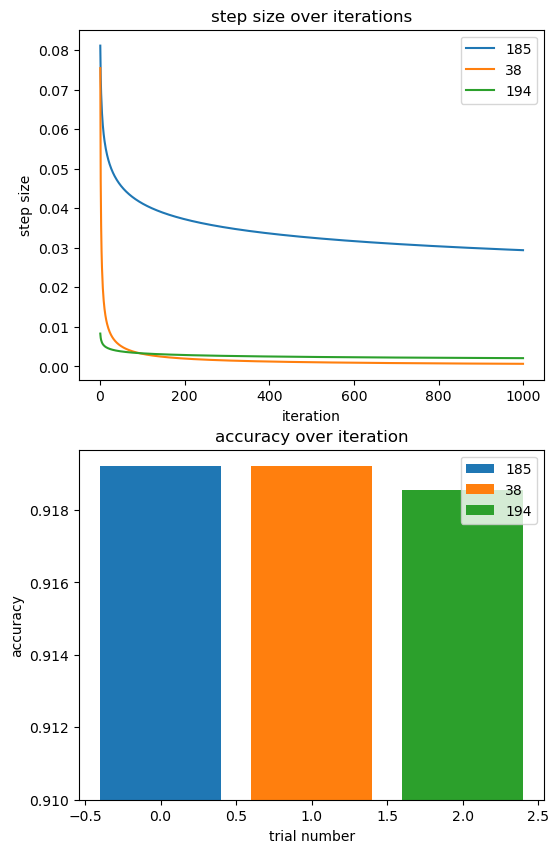

In [133]:
x = np.arange(1, 1000)
bottom_score = 0.91

fig, axs = plt.subplots(2, figsize=(6, 10))
for i, (trial_number, item) in enumerate(my_trials.items()):
    params = item['params']
    axs[0].set_title('step size over iterations')
    axs[0].set_xlabel('iteration')
    axs[0].set_ylabel('step size')
    axs[0].plot(x, params['step_alpha'] / x ** params['step_beta'], label=str(trial_number))

    axs[1].set_title('accuracy over iteration')
    axs[1].set_xlabel('trial number')
    axs[1].set_ylabel('accuracy')
    axs[1].bar(x=[i], height=[item['val_score'] - bottom_score], bottom=bottom_score, label=str(trial_number))
    

axs[0].legend()
axs[1].legend()
plt.show()  

Зеленая имеет меньший лосс чем синия, но скор у нее чуть лучше.

Обучите по модели на каждый trial, собирая историю на обучении и валидации. Положите обученные модели и полученные истории в словари по ключу trial.number.

In [37]:
prep = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='median')
)

features = data.select_dtypes(np.number).drop(columns=['target', 'sk_id_curr']).columns

X_tr_prep = prep.fit_transform(data_dict['tr'][features])
y_tr = data_dict['tr']['target'].values

X_val_prep = prep.transform(data_dict['val'][features])
y_val = data_dict['val']['target'].values


for trial_number, item in my_trials.items():
    
    params = item['params']

    loss_function = BinaryLogisticLoss(l2_coef=params['l2_coef'])
    linear_model = LinearModel(
        loss_function=loss_function,
        batch_size=params['batch_size'],
        step_alpha=params['step_alpha'],
        step_beta=params['step_beta'],
        tolerance=tolerance,
        max_iter=max_iter,
    )

    history = linear_model.fit(X_tr_prep, y_tr, None, True, X_val_prep, y_val)
    my_trials[trial_number]['model'] = linear_model
    my_trials[trial_number]['history'] = history



Напишите функцию `plot_trial_info`, которая выводит "информацию" о поданном trial. В эту "информацию" обязательно должно входить:
- График `feature - weight`, показывающий `top_k` признаков по модулю веса и их значения весов. Признаки должны идти по убыванию модуля веса.<br>Используйте `ax.barh`. <br> Используйте `ax.bar_label`, чтобы подписать веса к барам.<br> Используйте `ax.set_title(f'l2_coef: {l2_coef:.2e}', fontsize=15)` для этого графика.


- График "время обучения - лосс" - на обучении и валидации. Укажите "количество эпох | batch_size" в качестве title к этому графику. <br> Используйте `ax.plot`.


- Что угодно еще, что поможет вам принять решение о том, почему вы выберете один trial из этих трех.
<br><br>

Настройте размер графиков, шрифт, легенду. Убедитесь, что в вашей "информации" присутствует `trial.number, batch_size`. <br>
Визуализируйте выбранные вами trials. Убедитесь в адекватности графиков.

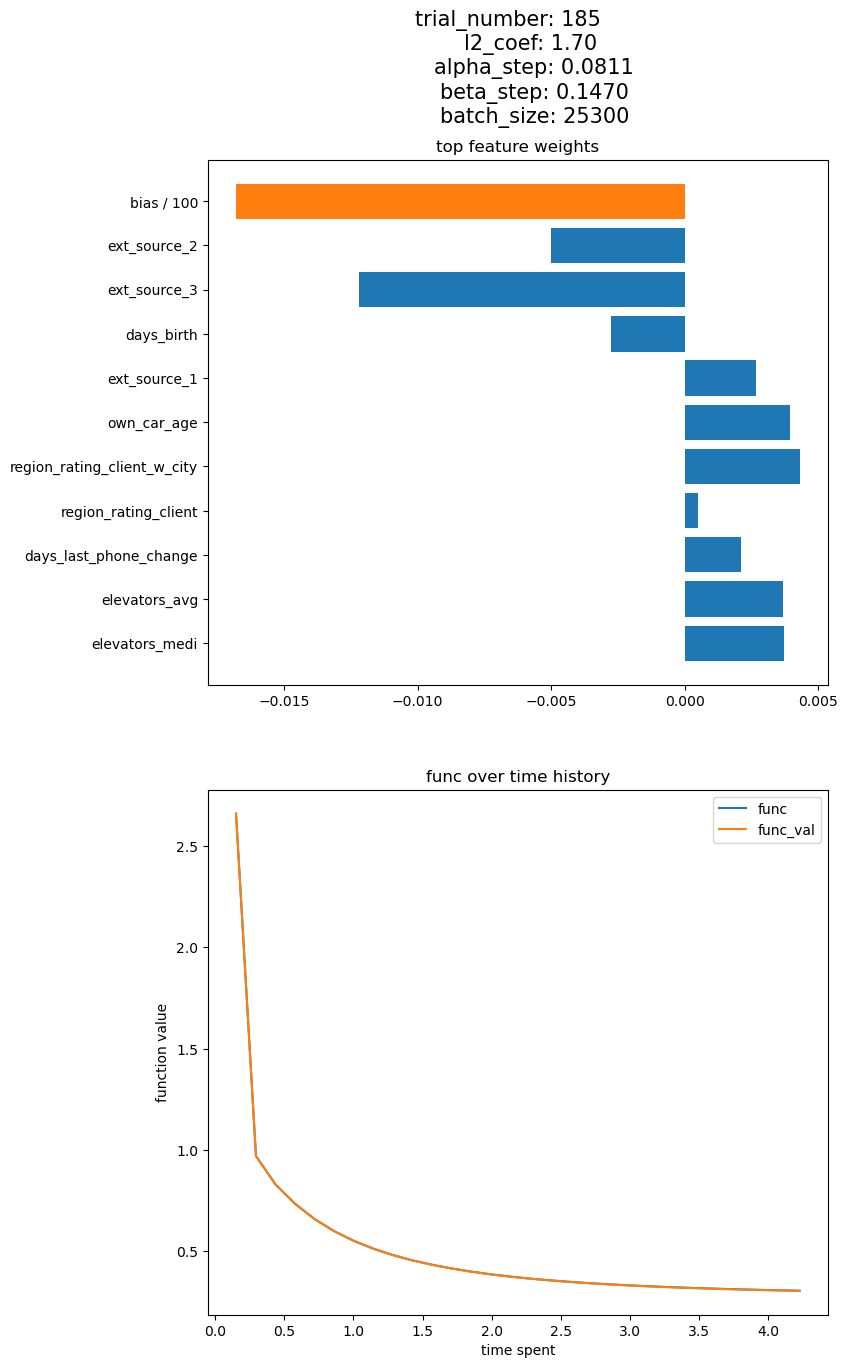

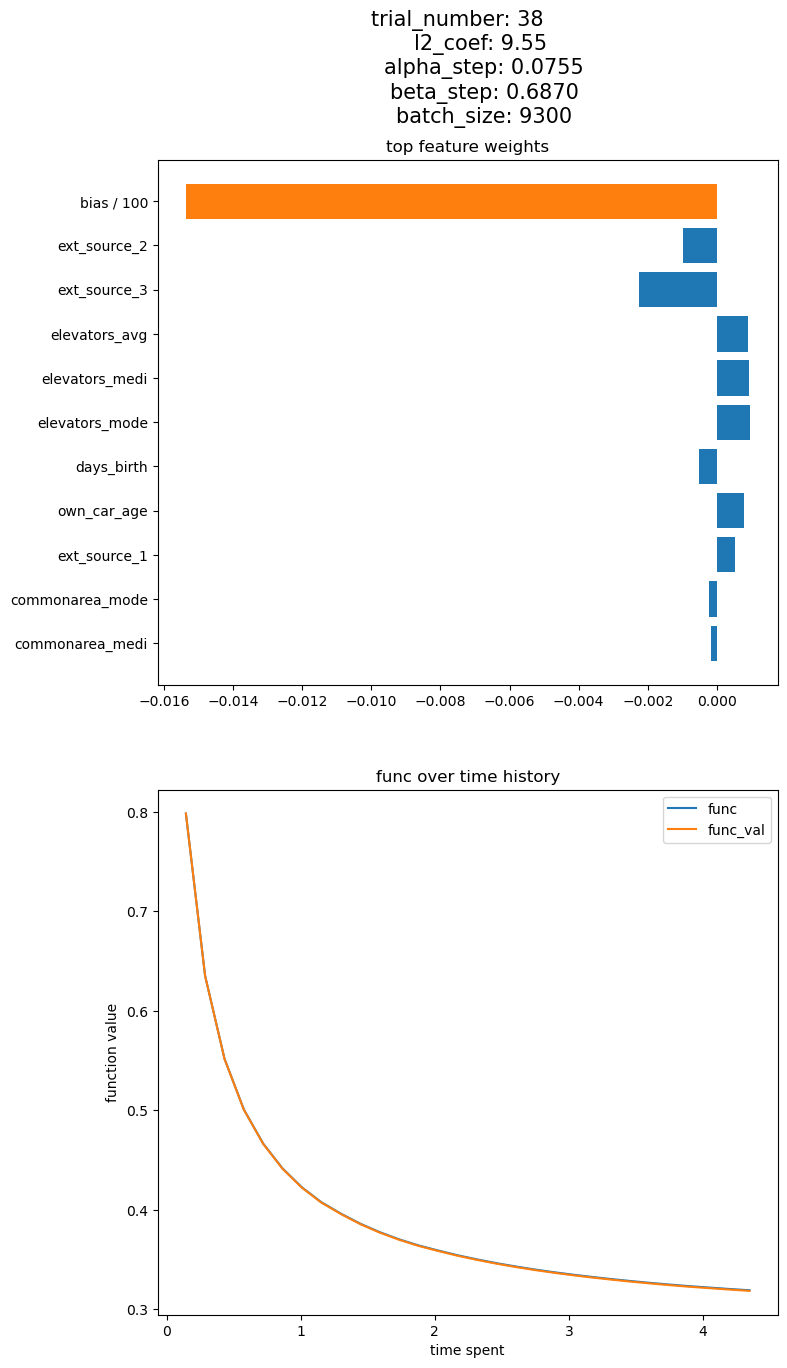

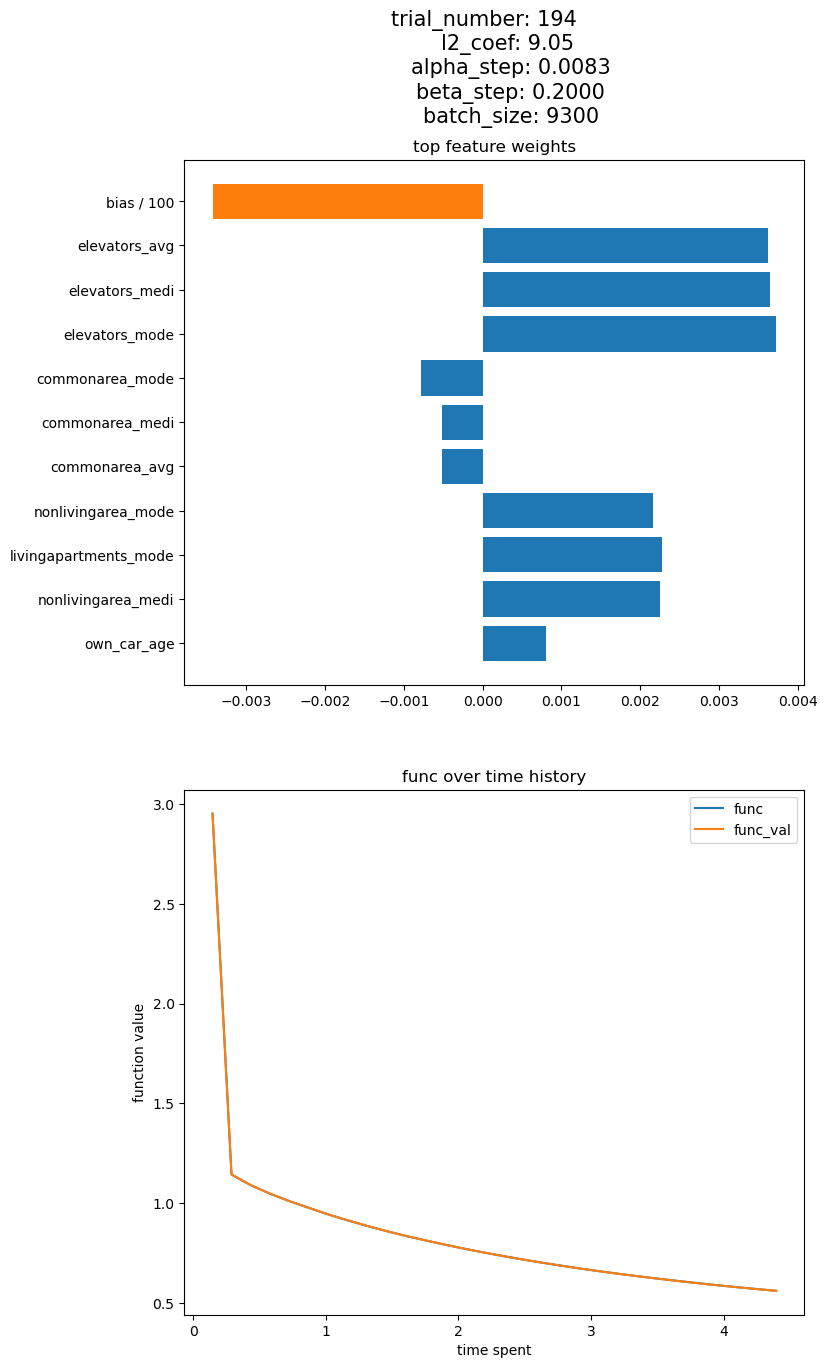

In [94]:
import matplotlib.pyplot as plt

#! Всю информацию о trial буду хранить по ключу в соответсвующем словаре
def plot_trial_info(trial, top_k, trial_number, *your_args, **your_kwargs):
    indx = np.argsort(np.abs(trial['model'].w[1:]))[-top_k:]
    l2_coef = trial['params']['l2_coef']
    step_alpha = trial['params']['step_alpha']
    step_beta = trial['params']['step_beta']
    batch_size = trial['params']['batch_size']


    fig, ax = plt.subplots(2, figsize=(8, 15))
    fig.suptitle(
        f"""
        trial_number: {trial_number}
        l2_coef: {l2_coef:.2f} 
        alpha_step: {step_alpha:.4f}
        beta_step: {step_beta:.4f}
        batch_size: {batch_size}
        """.strip(), 
        fontsize=15
    )

    ax[0].set_title('top feature weights')
    ax[0].barh(y=features[indx], width=trial['model'].w[indx])
    ax[0].barh(y=['bias / 100'], width=[trial['model'].w[0] / 100])
    

    ax[1].set_title('func over time history')
    ax[1].set_xlabel('time spent')
    ax[1].set_ylabel('function value')
    ax[1].plot(np.cumsum(trial['history']['time']), trial['history']['func'], label='func')
    ax[1].plot(np.cumsum(trial['history']['time']), trial['history']['func_val'], label='func_val')
    ax[1].legend()


    plt.show()

top_k = 10
for trial_number, trial in my_trials.items():
    plot_trial_info(trial, top_k=top_k, trial_number=trial_number)
    

Опишите свои наблюдения. Если нужно, подключите визуализацию.

Лосс на валидации и на трейне почти идеально совпадает везде.  
Видимо выборка очень простая и однородная.  
Веса у разных моделей различаются, но довольно сложно их сравнить,  
в целом картинки похожие и какого-то явного перевеса нет.

Какой в итоге коэффициент l2-регуляризации будем фиксировать для дальнейших экспериментов? <br>
Ответ объясните :)

Все графики выглядят крайне похоже.  
Я бы выбрал `l2_coef=9.05` так как этот вариант имеет меньший `bias` чем вариант с почти таким же штрафом. При этом `l2_coef=1.7` как будто бы переоценил веса.  

In [99]:
trian_number = 194

### Часть вторая. Research (6 баллов)

Давайте зафиксируем выбранный коэффициент регуляризации и проведем несколько экспериментов с `step_alpha, step_beta, batch_size`. Но для начала посмотрим - возможно, нам удастся уменьшить размер признакового пространства без сильной потери качества, чтобы ускорить наши эксперименты.

Достаньте из словаря модель, соответствующую выбранному вами лучшему trial, и нарисуйте график отсортированных модулей ее весов.

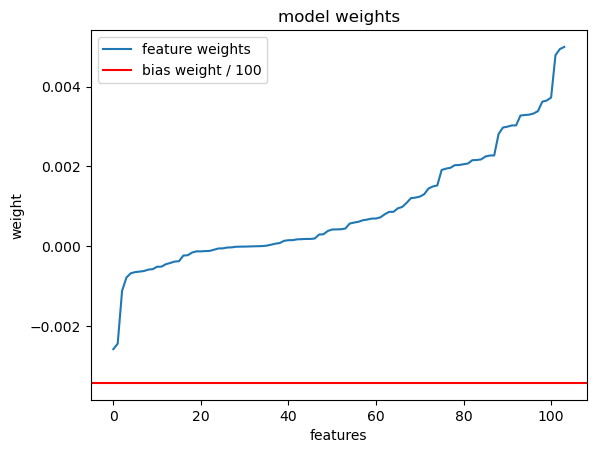

In [105]:
plt.title('model weights')
plt.plot(np.arange(len(features)), np.sort(my_trials[trial_number]['model'].w[1:]), label='feature weights')
plt.axhline(y=my_trials[trial_number]['model'].w[0] / 100, c='red', label='bias weight / 100')
plt.xlabel('features')
plt.ylabel('weight')
plt.legend()
plt.show()


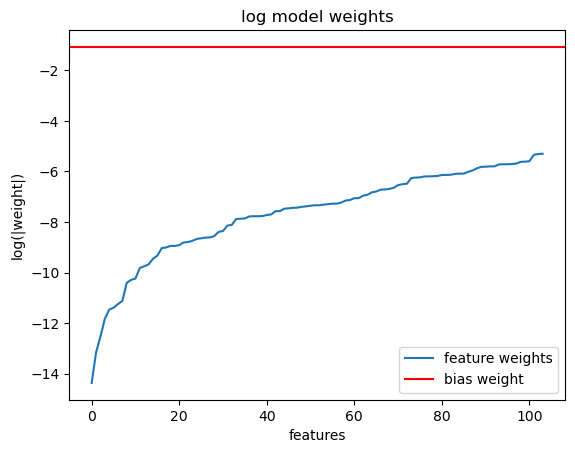

In [107]:
plt.title('log model weights')
plt.plot(
    np.arange(len(features)), 
    np.sort(np.log(np.abs(my_trials[trial_number]['model'].w[1:]))), 
    label='feature weights'
)
plt.axhline(y=np.log(np.abs(my_trials[trial_number]['model'].w[0])), c='red', label='bias weight')
plt.xlabel('features')
plt.ylabel('log(|weight|)')
plt.legend()
plt.show()

Подумайте, можно ли убрать какую-то долю признаков? Если да, то какие признаки вы уберете для дальнейших экспериментов? <br>
Ответ объясните. Могут ли возникнуть какие-то проблемы в дальнейшем?

На графике с логорифмом видны некоторые бугры, я бы попробовал отрезать фичи по ним влево.  
Таким образом мы убурем фичи которые наиболее слабо влияют на ответ.

Напишите новую функцию `research_objective` для перебора `step_alpha, step_beta` при фиксированных `l2_coef, batch_size`. Остальные гиперпараметры оставьте без изменений с прошлого раза. Для перебора step_alpha используйте log-шкалу от 1e-3 до 20, для перебора step_beta - log-шкалу от 0.1 до 5.

Для `batch_size = 300, 1000, 10000, None` запустите по сессии оптимизации на выбранном вами (под)множестве признаков, собирая каждый `study` в словарик по ключу batch_size. Используйте `n_trials = 200`, TPESampler с параметром `n_startup_trials = 100`.<br>

In [110]:
l2_coef = my_trials[trial_number]['params']['l2_coef']

def objective(trial, X_tr, y_tr, X_val, y_val):
    # Global variables
    tolerance = globals()['tolerance']
    max_iter = globals()['max_iter']
    np.random.seed(globals()['random_seed'])

    # alpha - изначальное значение learning_rate
    # мне кажется оно должно быть около 1e-2 - 1e-1
    # больше кажется брать нет смысла, и почти всегда оно будет
    # достаточно быстро уменьшаться.
    step_alpha = trial.suggest_float('step_alpha', 1e-3, 20, log=True)

    # beta - скорость уменьшения learning_rate
    # мне кажется что beta должна быть между 0 и 1.
    # При beta < 0 learning_rate начнет увеличиваться.
    # При beta > 1 сумма learning_rate сходится и мы можем не дойти до оптимума
    step_beta = trial.suggest_float('step_beta', 0.1, 5, log=True)

    # Следуя указаниям минимальный bathc_size = 300.
    # Максимальный len(X_tr). Надеюсь влезет в память
    batch_size = trial.suggest_categorical('batch_size', [300, 1_000, 10_000, None])

    l2_coef = globals()['l2_coef']

    loss_function = BinaryLogisticLoss(l2_coef=l2_coef)
    linear_model = LinearModel(
        loss_function=loss_function,
        batch_size=batch_size,
        step_alpha=step_alpha,
        step_beta=step_beta,
        tolerance=tolerance,
        max_iter=max_iter,
    )

    linear_model.fit(X_tr, y_tr)
    y_pred = linear_model.predict(X_val)

    # Для первого варианта accuracy сойдет
    # Хотя сейчас я думаю что такое большое значение bias 
    # По сравнению с фичами, могло быть вызвано несбалансированностью классов
    return np.mean(y_pred == y_val)



In [111]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

gamma = lambda n_trials: min(int(np.ceil(0.1 * n_trials)), 25)
tpe_sampler = optuna.samplers.TPESampler(n_startup_trials=100, n_ei_candidates=24, gamma=gamma)

study = start_optimization(
    objective,
    n_trials=200,
    n_jobs=12,
    data_dict=data_dict,
    sampler=tpe_sampler,
)

/home/denis/Documents/AI_Masters/Machine_Learning_1/hw/hw4/modules/losses.py:26: RuntimeWarning:

overflow encountered in matmul

/home/denis/Documents/AI_Masters/Machine_Learning_1/hw/hw4/modules/losses.py:26: RuntimeWarning:

invalid value encountered in matmul

/home/denis/Documents/AI_Masters/Machine_Learning_1/hw/hw4/modules/losses.py:86: RuntimeWarning:

overflow encountered in multiply

/home/denis/Documents/AI_Masters/Machine_Learning_1/hw/hw4/modules/losses.py:17: RuntimeWarning:

invalid value encountered in logaddexp

/home/denis/Documents/AI_Masters/Machine_Learning_1/hw/hw4/modules/losses.py:65: RuntimeWarning:

overflow encountered in matmul

/home/denis/Documents/AI_Masters/Machine_Learning_1/hw/hw4/modules/linear_model.py:90: RuntimeWarning:

invalid value encountered in double_scalars

/home/denis/Documents/AI_Masters/Machine_Learning_1/hw/hw4/modules/linear_model.py:87: RuntimeWarning:

overflow encountered in multiply

/home/denis/miniconda3/lib/python3.9/site-packag

Используя `optuna.visualization.plot_contour`, нарисуйте график зависимости `step_alpha - step_beta - objective`. Используйте аргумент `target`, чтобы обрезать значения лоссов, которые портят тепловую карту. <br>
Для каждого `batch_size` выведите такой график в отдельной ячейке.

In [130]:
def clipper_example(frozen_trial):
    #! Почему мы хотим отрезать большие лоссы, наверное наоборот маленькие
    max_value = 0.8
    return min(frozen_trial.value, max_value)

def myclipper_example(frozen_trial):
    min_value = 0.8
    return max(frozen_trial.value, min_value)

# Неясно как разделить на батчи
optuna.visualization.plot_contour(
    study,
    params=['step_alpha', 'step_beta'], 
    # Как с помощью этого обрезать значения - неясно
    target=myclipper_example, 
)

Опишите подробно все свои наблюдения.

Есть пары `alpha_step, beta_step` которые дают одинаковые результаты.  
На примере который я рисовал выше кривые шага не совсем совпали, но можно подобрать `trials` таким образом что `alpha_step, beta_step` сильно разные, а длины шагов очень хорошо накладываются

Мы поставили довольно большое значение `n_startup_trials` в TPESampler. Как думаете, для чего?

Чтобы изначально было множество попыток с различными наборами параметров.  
Кажется `optuna` достаточно быстро находит наиболее оптимальные параметры для такой простой модели.

Обучите по модели для каждого `batch_size` с лучшими `step_alpha, step_beta`. Соберите историю, сложите все в словари по ключу batch_size.

In [138]:
from collections import defaultdict

In [139]:
step_alpha = study.best_params['step_alpha']
step_beta = study.best_params['step_beta']

batch_size_models = defaultdict(dict)
for batch_size in [300, 1_000, 10_000, None]:
    
    loss_function = BinaryLogisticLoss(l2_coef=params['l2_coef'])
    linear_model = LinearModel(
        loss_function=loss_function,
        batch_size=batch_size,
        step_alpha=step_alpha,
        step_beta=step_beta,
        tolerance=tolerance,
        max_iter=max_iter,
    )

    history = linear_model.fit(X_tr_prep, y_tr, None, True, X_val_prep, y_val)
    batch_size_models[batch_size]['model'] = linear_model
    batch_size_models[batch_size]['history'] = history

Визуализируйте результаты эксперимента. Нарисуйте графики `time-loss`, `epoch-loss`, `epoch-learning_rate` для каждого `batch_size`. <br>
На графике `epoch-loss` должно быть каким-либо образом отображено среднее время эпохи для каждого размера батча. <br>
Под `learning_rate` имеется в виду:
$$\eta_k  = \frac{\alpha}{k^{\beta}}, \quad \text{где $k$ - номер итерации (эпохи)}$$

Убедитесь, что различия между графиками, относящимися к разным `batch_size`, хорошо видны.

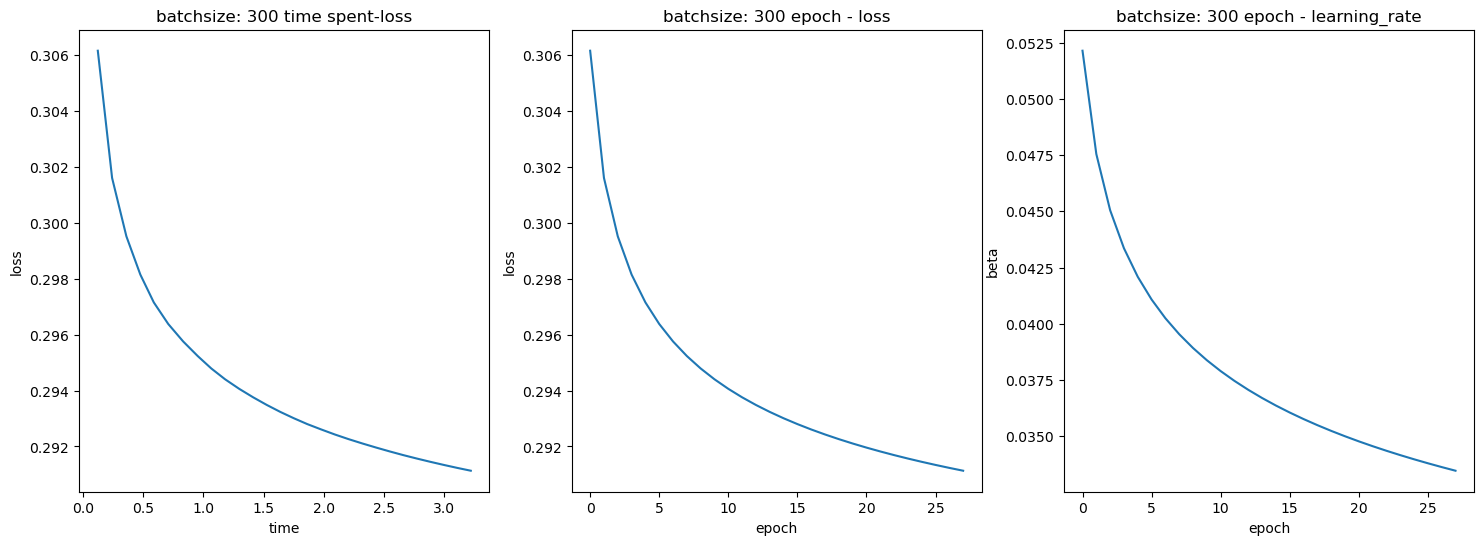

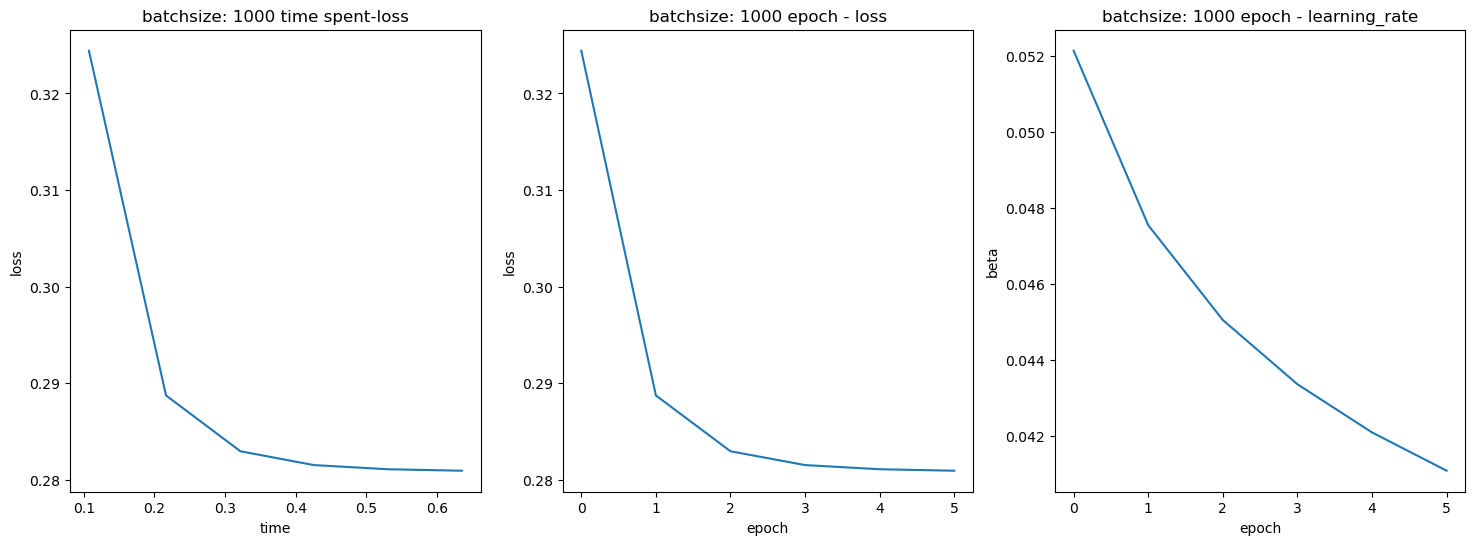

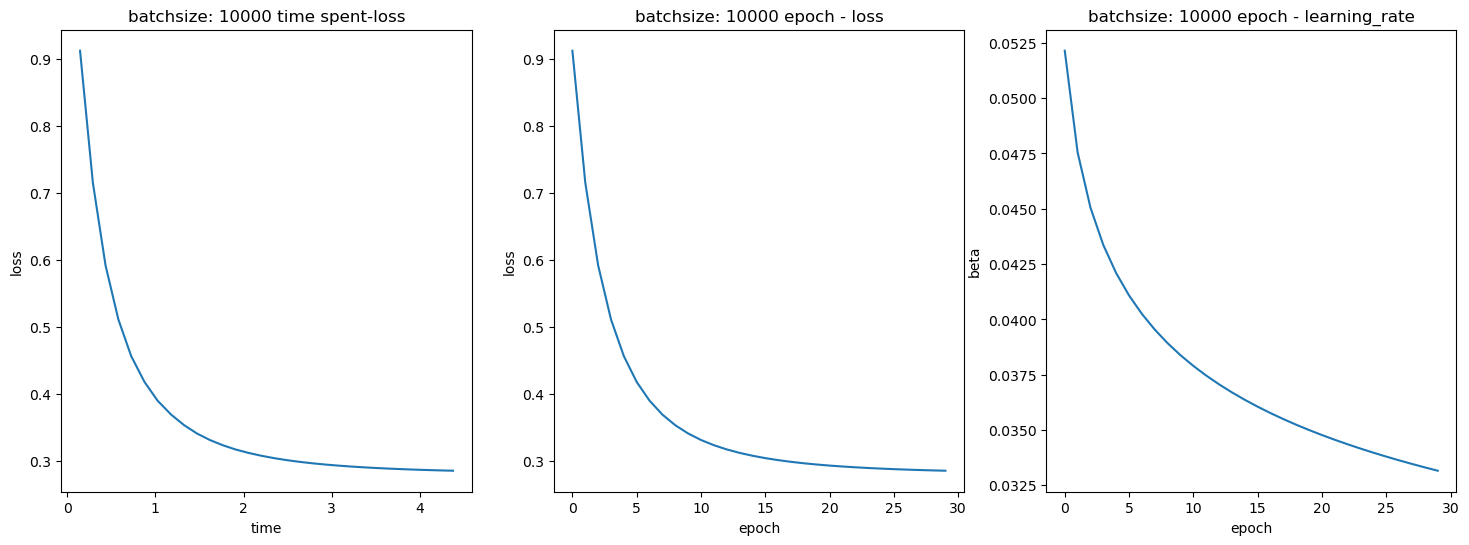

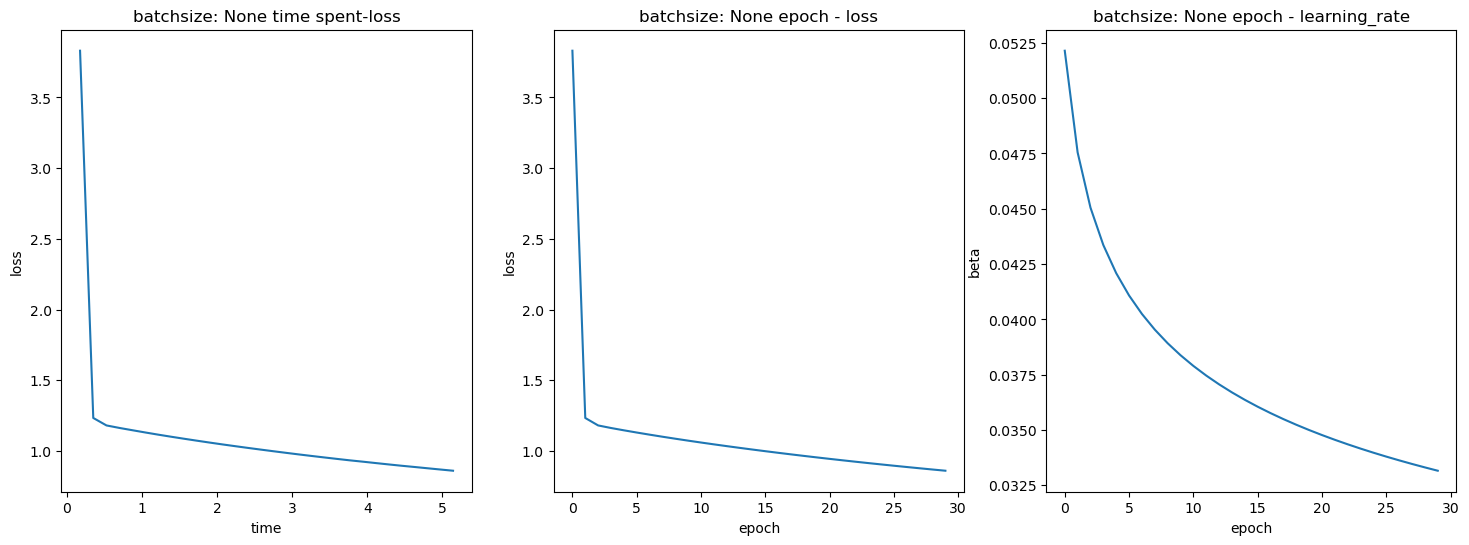

In [151]:
for batch_size, info in batch_size_models.items():

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    time = np.cumsum(info['history']['time'])
    func = info['history']['func']
    func_val = info['history']['func_val']

    ax[0].set_title(f'batchsize: {batch_size} time spent-loss')
    ax[0].plot(time, func_val)
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('time')

    ax[1].set_title(f'batchsize: {batch_size} epoch - loss')
    ax[1].plot(np.arange(len(func_val)), func_val)
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    

    ax[2].set_title(f'batchsize: {batch_size} epoch - learning_rate')
    ax[2].plot(np.arange(len(func_val)), step_alpha / np.arange(1, len(func_val) + 1) ** step_beta)
    ax[2].set_ylabel('beta')
    ax[2].set_xlabel('epoch')
    plt.show()

Какие выводы можно сделать из увиденного?

Зависимость немонотонная.  
По количеству итераций
1. None - самый большой batch_size и почти самый большой по времени. Так же несмотря на количество итераций очень резкий
2. 10_000 похож на None но сильно более гладкий.
3. 1000 имеет мало итераций как следствие резкий и быстрый
4. 300 снова много итераций, плавный и дольше 1000, хотя быстрее остальных.

### Часть третья. Метрика (4 балла)

Настало время проверить, во что вылились наши усилия. Посмотрим на метрику `sklearn.metrics.balanced_accuracy_score`.

Выберите по графикам выше оптимальные параметры для вашей финальной модели. Посчитайте для этой модели значение `balanced_accuracy` на обучающей, валидационной и тестовой выборках. Используйте `model.get_optimal_threshold` для подсчета порога бинаризации.

In [153]:
from sklearn.metrics import balanced_accuracy_score

step_alpha = step_alpha
step_beta = step_beta
l2_coef = l2_coef
batch_size = 1000

loss_function = BinaryLogisticLoss(l2_coef=params['l2_coef'])
linear_model = LinearModel(
    loss_function=loss_function,
    batch_size=batch_size,
    step_alpha=step_alpha,
    step_beta=step_beta,
    tolerance=tolerance,
    max_iter=max_iter,
)

linear_model.fit(X_tr_prep, y_tr)
y_pred = linear_model.predict(X_val_prep)

balanced_accuracy_score(y_val, y_pred)

0.5

Что скажете?

Как я писал выше, меня смутил очень высокий bias модели.  
Что навело на мысли о том, что фичи вообще никак не влияют на предсказания  
и модель просто всегда одно и тоже предсказывает.  
`balanced_accuracy_score` это подтвердил 🥲  
Не стоило выбирать `accuracy` как метрику для того чтобы потестить.

В качестве послесловия предлагается на обсуждение вопрос, который мог возникнуть еще в самом начале экспериментов: почему мы подбираем гиперпараметры по лоссу, если в результате мы хотим получить модель с лучшим показателем метрики `balanced_accuracy`? Первое, что хочется ответить, так это то, что каждый раз подбирать оптимальный порог и считать метрику дольше, чем просто посчитать лосс.

  Замерьте время подсчета лосса и подбора оптимального порога + подсчет метрики, [используя](https://ipython.readthedocs.io/en/stable/interactive/magics.html) `%timeit` или `%%timeit`.

Кажется я еще и пропустил предложение о том, что надо использовать `loss` для `optune` а не просто какую то метрику.  
Хотя результат наверное не сильно изменится, потому что `loss` так же не учитывает баланс классов. 

In [155]:
%%timeit
loss_function.func(X_val_prep, y_val, linear_model.w)
linear_model.get_optimal_threshold(X_val_prep, y_val)

169 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [156]:
%%timeit
balanced_accuracy_score(y_val, y_pred)

32.4 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Казалось бы подсчет метрики занимает не так уж и много времени  
можно было бы добавить

Подумайте (и напишите), есть ли другие причины, по которым использовать `balanced_accuracy` в нашем процессе подбора гиперпараметров не стоит?

По логике, уменьшение лосса есть "улучшение качества работы алгоритма", как и увеличение нашей метрики. Может быть, мы имели право перебирать гиперпараметры по лоссу, даже если на самом деле хотели от модели лишь `balanced_accuracy` побольше?

Давайте проверим. Напишите функцию `multiobjective`, которая перебирает `step_alpha, step_beta`. Зафиксируйте все остальное на адекватных значениях, согласно предыдущим экспериментам. Функция должна возвращать tuple `(loss, balanced_acc_score)` - лосс и balanced_accuracy_score с подбором оптимального порога, полученные на валидации.

In [ ]:
# your code here

Optuna [позволяет](https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/002_multi_objective.html#sphx-glr-tutorial-20-recipes-002-multi-objective-py) оптимизировать `multiobjective-функции`, которые возвращают больше одного аргумента.

Запустите сессию оптимизации с сэмплером по умолчанию. Используйте 100-300 `n_trials`, `study_directions = ['minimize', 'maximize']`.

In [ ]:
# your code here

С помощью `optuna.visualization.plot_pareto_front` визуализируйте результаты сессии. В разных ячейках используйте разные значения аргумента `include_dominated_trials`. Используйте зум для выделения наглядной зоны, если необходимо. Подпишите ваши objectives с помощью аргумента `target_names`.

In [ ]:
# your code here

In [ ]:
# your code here

Что вы можете сказать об увиденном?

Ура! А теперь...

## Бонусная часть. Постигая ASHA (7 баллов)

В бонусной части забудем датасет и линейные модели! Вам предстоит наглядно убедиться и разобраться в том, как работает `optuna.pruners.SuccessiveHalvingPruner`, он же **ASHA**. Важно понимать, как устроены `optuna.pruners` - правильное их использование заметно сократит время ожидания и может улучшить качество.

В вашем распоряжении семинар, документация и исходный код классов в `optuna`.

### 0
Начнем с простого - будем использовать предложенный простенький `objective`, чтобы убедиться, что все `trials` успешно доходят до конца.

Все указанные параметры не изменяйте в дальнейшем, если этого не просят в задании.

In [ ]:
def objective_0(trial):
    for i in range(31):
        trial.report(val=trial.number, step=i)
        if trial.should_prune():
            raise optuna.TrialPruned()
    return 0

pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=2, reduction_factor=2,
                                                bootstrap_count=0, min_early_stopping_rate=0)
study = optuna.create_study(direction='maximize', pruner=pruner)

study.optimize(objective_0, n_trials=16, n_jobs=4)

Давайте визуализируем наш `study`. Напишите функцию `plot_study_info`, отрисовывающую жизненный путь всех `trials`. Используйте данный ниже шаблон. Под визулизацией будем понимать нечто похожее на картинки с семинара:

- ось Х - `step`, ось Y - `trial.number`.

- каждый trial - горизонтальная синяя прямая от -1 до `trial.last_step`.

- если trial [дошел до конца](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.TrialState.html#optuna.trial.TrialState), на конце прямой поставьте зеленый кружок, если обрезался - красный крестик [`plt.scatter(..., marker=...)`].

- синяя вертикальная прямая на отметке `step = 0` - "день рождения" trial.

- черными вертикальными прямыми расставьте `rungs`. Воспользуйтесь [исходным кодом](https://optuna.readthedocs.io/en/stable/_modules/optuna/pruners/_successive_halving.html#SuccessiveHalvingPruner) `SuccessiveHalvingPruner` для выяснения всех обстоятельств.

- зелеными вертикальными линиями отметьте те `steps`, на которых делается `trial.report`. Сделайте так, чтобы эти линии были видны поверх линий, обозначающих `rungs`, если такие случаи будут иметь место.

- что еще хотите от себя! Учтите, что trials после сессии оптимизации являются [`FrozenTrials`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.FrozenTrial.html#optuna.trial.FrozenTrial).

Пожалуйста, уделите должное внимание этой функции и отладьте ее. Убедитесь, что все хорошо видно, что все адекватного размера. Вы будете ее часто использовать далее.

In [ ]:
def plot_study_info(study, min_resource, max_resource, gamma, early_stopping=0, *your_args, **your_kwargs):
    # your code here
    pass

Визуализируйте первую сессию, используя вашу фукнцию. Что в данном случае такое `max_resource`?

In [ ]:
# your code here

Почему все trials дошли до конца?

### 1

Напишите новый `objective` - попробуйте порепортить случайные значения, устроив беспорядок. Создайте новый `study` и запустите сессию оптимизации с теми же параметрами. Визуализируйте процесс и убедитесь, что все правильно. Далее, эту цепочку будем называть "запустите и визуализируйте".

In [ ]:
# your code here

Что-нибудь интересное на картинке?

### 2

Теперь напишите еще один `objective` - все должны дойти до конца, но теперь не по порядку, то есть i-й по скорости trial не должен иметь `trial.number = i - 1`. Запустите и визуализируйте.

In [ ]:
# your code here

Объясните, как вы добились того, что trials заканчивают не по порядку.

### 3

Оставьте прошлый `objective` и положите `bootstrap_count=2`. Запустите и визуализируйте.

In [ ]:
# your code here

Как в итоге работает этот аргумент?

### 4

Напишите новый `objective`, чтобы `trial.report` не всегда приходился на `step = rung`. Запустите и визуализируйте.

In [ ]:
# your code here

Объясните увиденное

### 5

Используя предыдущий `objective`, запустите сессии с аргументом прунера `min_early_stopping = 0, 1, 2, 3`.

Визуализируйте их друг под другом. Если к этому моменту вы убедились, что ваша рисовалка работает правильно, используйте `optuna.logging.set_verbosity`, чтобы скрыть вывод о ходе сессии.

In [ ]:
# your code here

Объясните, за что отвечает этот аргумент и при чем здесь `early_stopping`.

### 6

Мы достигли достаточного уровня мастерства чтобы визуализировать `optuna.pruners.HyperbandPruner`! `Hyperband` создает несколько `brackets`, отправляя тот или иной trial в тот или иной `bracket` по хэшу. Подробнее - см. семинар, 
[описание](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.HyperbandPruner.html) или 
[исходный код](https://optuna.readthedocs.io/en/stable/_modules/optuna/pruners/_hyperband.html#HyperbandPruner).

Используя `objective` на ваш вкус, создайте новый `study` с `HyperbandPruner`. Подберите `max_resource` так, чтобы получилось 4 брэкета. На что еще влияет `max_resource` в `HyperbandPruner`?

Запустите и визуализируйте брэкеты друг под другом. Если нужно, напишите новую фукнцию для отрисовки брэкетов по `study`, хотя по сути - прошлая функция как раз отрисовывала один брэкет; возможно, можно лишь немного изменить её.

In [ ]:
# your code here

Опишите свои наблюдения.

### 7. Босс!

Отрисуйте слепки одного брэкета (используйте `ASHA`) в режиме реального времени, используя `ask-tell` интерфейс вместо `study.optimize`. Например, вы можете рисовать состояние брэкета (в данном случае, `study = bracket`) когда появляется каждый второй trial. Используйте `time.sleep` для того чтобы сделать картинку интереснее. Подумайте, как лучше отрисовывать, чтобы хорошо было видно развитие сюжета. Если нужно, используйте другую функцию для отрисовки. 

In [ ]:
# your code here

Опишите свои наблюдения.

Еще одно ура! Как впечатления?